In [41]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#  LSST imports:
import lsst.afw.image as afw_image
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit

posImage = afw_image.ExposureF('calexp-0289820_11.fits')
negImage = afw_image.ExposureF('matchexp-11.fits')
diffim = afw_image.ExposureF('diffexp-11.fits')

plt.imshow(posImage.getPsf().computeImage().getArray(), interpolation='none')
plt.imshow(diffim.getPsf().computeImage().getArray()-posImage.getPsf().computeImage().getArray(), interpolation='none')

Code from `ip_diffim/tests/subtractExposures.py` ...

In [12]:
import os
import sys
import lsst.utils
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.pex.logging as logging
import lsst.ip.diffim.diffimTools as diffimTools

verbosity = 5
logging.Trace_setVerbosity('lsst.ip.diffim', verbosity)
logging.Trace_setVerbosity('ImagePsfMatchTask', verbosity)

display = False

In [24]:
# D = I - (K.x.T + bg)

config    = ipDiffim.ImagePsfMatchTask.ConfigClass()
config.kernel.name = "AL"
subconfig = config.kernel.active

# Some of the tests are sensitive to the centroids returned by
# "stdev" vs "pixel_stdev"
subconfig.detectionConfig.detThresholdType = "stdev"

# Impacts some of the test values
subconfig.constantVarianceWeighting = True

try:
    defDataDir = lsst.utils.getPackageDir('afwdata')    
    defTemplatePath = os.path.join(defDataDir, "DC3a-Sim", "sci", "v5-e0",
                                   "v5-e0-c011-a00.sci.fits")
    defSciencePath = os.path.join(defDataDir, "DC3a-Sim", "sci", "v26-e0",
                                  "v26-e0-c011-a00.sci.fits")

    scienceImage   = afwImage.ExposureF(defSciencePath)
    templateImage  = afwImage.ExposureF(defTemplatePath)

    bgConfig = subconfig.afwBackgroundConfig
    bgConfig.useApprox = False
    bgConfig.binSize = 512
    diffimTools.backgroundSubtract(bgConfig,
                                   [templateImage.getMaskedImage(),
                                    scienceImage.getMaskedImage()])

    offset   = 1500
    bbox     = afwGeom.Box2I(afwGeom.Point2I(0, offset),
                                  afwGeom.Point2I(511, 2046))
    subconfig.spatialKernelOrder = 1
    subconfig.spatialBgOrder = 0

    # Take a stab at a PSF.  This is needed to get the KernelCandidateList if you don't provide one.
    ksize  = 21
    sigma = 2.0
    psf = measAlg.DoubleGaussianPsf(ksize, ksize, sigma)
    scienceImage.setPsf(psf)
except Exception:
    print >> sys.stderr, "Warning: afwdata is not set up"
    defDataDir = None

In [82]:
subconfig.fitForBackground = True

print bbox
templateSubImage = afwImage.ExposureF(templateImage, bbox)
scienceSubImage  = afwImage.ExposureF(scienceImage, bbox)

subconfig.spatialModelType = 'chebyshev1'
psfmatch1 = ipDiffim.ImagePsfMatchTask(config=config)
results1 = psfmatch1.subtractExposures(templateSubImage, scienceSubImage, doWarping = True)
spatialKernel1      = results1.psfMatchingKernel
backgroundModel1    = results1.backgroundModel

subconfig.spatialModelType = 'polynomial'
psfmatch2 = ipDiffim.ImagePsfMatchTask(config=config)
results2 = psfmatch2.subtractExposures(templateSubImage, scienceSubImage, doWarping = True)
spatialKernel2      = results2.psfMatchingKernel
backgroundModel2    = results2.backgroundModel

print spatialKernel1.getSpatialFunctionList()[0].toString()

# First order term has zero spatial variation and sum = kernel sum
kp1par0 = spatialKernel1.getSpatialFunctionList()[0].getParameters()
kp2par0 = spatialKernel2.getSpatialFunctionList()[0].getParameters()
#self.assertAlmostEqual(kp1par0[0], kp2par0[0], delta=1e-5)
print kp1par0[0], kp2par0[0]

# More improtant is the kernel needs to be then same when realized at a coordinate
kim1 = afwImage.ImageD(spatialKernel1.getDimensions())
kim2 = afwImage.ImageD(spatialKernel2.getDimensions())
ksum1 = spatialKernel1.computeImage(kim1, False, 0.0, 0.0)
ksum2 = spatialKernel2.computeImage(kim2, False, 0.0, 0.0)
#self.assertAlmostEqual(ksum1, ksum2, delta=1e-5)
print ksum1, ksum2
#for y in range(kim1.getHeight()):
#    for x in range(kim1.getHeight()):
#        self.assertAlmostEqual(kim1.get(x, y), kim2.get(x, y), delta=1e-1)

# Nterms (zeroth order)
print backgroundModel1.getNParameters(), backgroundModel2.getNParameters()

# Zero value in function
print backgroundModel1.getParameters()[0], backgroundModel2.getParameters()[0]

# Function evaluates to zero
print backgroundModel1(0, 0), backgroundModel2(0, 0)

# Spatially...
print backgroundModel1(10, 10), backgroundModel2(10, 10)

Box2I((0, 1500), (511, 2046))
Chebyshev1Function2 [1, Box2D(Point2D(-0.5, 1499.5), Extent2D(512, 547))]Function2: parameters: [ 0.997776, 0, 0 ]
0.997775617817 0.997775755489
0.997775617817 0.997775755489
1 1
-0.149600615398 -0.149569257519
-0.149600615398 -0.149569257519
-0.149600615398 -0.149569257519


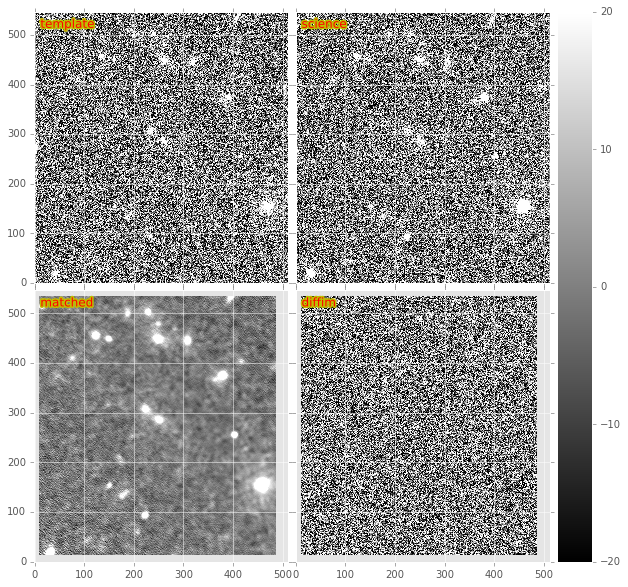

In [70]:
dit.plotImageGrid((templateSubImage.getMaskedImage().getArrays()[0], 
               scienceSubImage.getMaskedImage().getArrays()[0],
              results1.matchedImage.getArrays()[0], 
               results1.subtractedExposure.getMaskedImage().getArrays()[0]), 
              imScale=5., clim=(-20,20), 
              titles=['template', 'science', 'matched', 'diffim'])

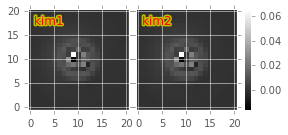

In [93]:
# Note this was computed at coord (0,0) which is way off-center from the input images.
dit.plotImageGrid((kim1.getArray(), kim2.getArray()), titles=['kim1', 'kim2'])

OK, compute the correction kernel... For now, we force two assumptions:

1. use the median image variance as $\sigma^2$
2. use the matching kernel from the center of the image, not using spatially varying version

256.0 1773.5
1.0 1.0


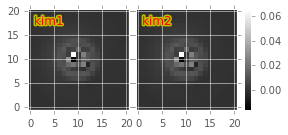

In [85]:
xcen = (bbox.getBeginX() + bbox.getEndX()) / 2.
ycen = (bbox.getBeginY() + bbox.getEndY()) / 2.
print xcen, ycen
ksum1 = spatialKernel1.computeImage(kim1, True, xcen, ycen)
ksum2 = spatialKernel2.computeImage(kim2, True, xcen, ycen)
print ksum1, ksum2
dit.plotImageGrid((kim1.getArray(), kim2.getArray()), titles=['kim1', 'kim2'])

DescribeResult(nobs=280064, minmax=(531.0, 34527.0), mean=642.10748, variance=37816.43, skewness=119.09103393554688, kurtosis=16063.202338812966)
DescribeResult(nobs=280064, minmax=(518.0, 7683.0), mean=642.10431, variance=7966.2725, skewness=48.67700958251953, kurtosis=2888.090659364118)
(639.70947, 23.770779)
(639.83264, 23.681673)


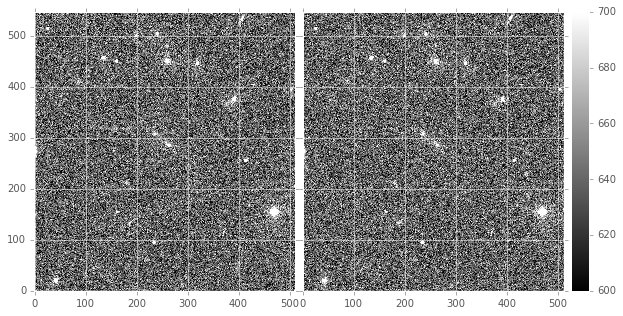

In [65]:
import scipy.stats
reload(dit)

sig1 = templateSubImage.getMaskedImage().getVariance().getArray()
print scipy.stats.describe(sig1, None)
sig2 = scienceSubImage.getMaskedImage().getVariance().getArray()
print scipy.stats.describe(sig2, None)
print dit.computeClippedImageStats(sig1)
print dit.computeClippedImageStats(sig2)
sig1squared, _ = dit.computeClippedImageStats(sig1)
sig2squared, _ = dit.computeClippedImageStats(sig2)
dit.plotImageGrid((sig1, sig1), imScale=5., clim=(600,700))

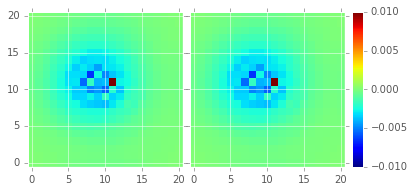

In [96]:
corrKernel1 = dit.computeCorrectionKernelALZC(kim1.getArray(), sig1=np.sqrt(sig1squared), sig2=np.sqrt(sig2squared))
corrKernel2 = dit.computeCorrectionKernelALZC(kim2.getArray(), sig1=np.sqrt(sig1squared), sig2=np.sqrt(sig2squared))
dit.plotImageGrid((corrKernel1, corrKernel2), imScale=3., clim=(-0.01,0.01), cmap=None)

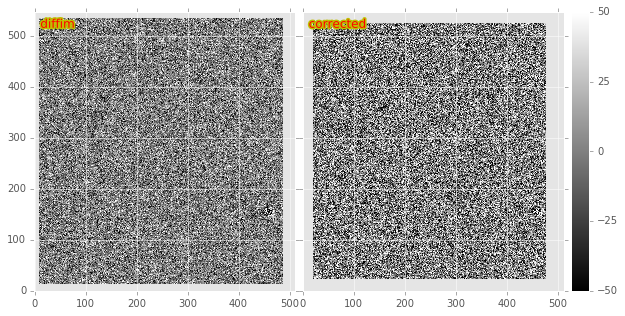

In [97]:
import scipy.ndimage.filters
diffim = results1.subtractedExposure.getMaskedImage().getArrays()[0]
pci = scipy.ndimage.filters.convolve(diffim, corrKernel, mode='constant')

dit.plotImageGrid((diffim, pci), 
              imScale=5., clim=(-50,50), 
              titles=['diffim', 'corrected'])

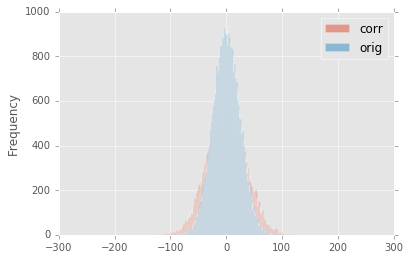

In [98]:
import pandas as pd

df = pd.DataFrame({'corr': pci.flatten(), 'orig': diffim.flatten()})
df.plot.hist(alpha=0.5, bins=2000)
#plt.xlim(-0.5, 0.5)

0.119816916865
0.013676275969


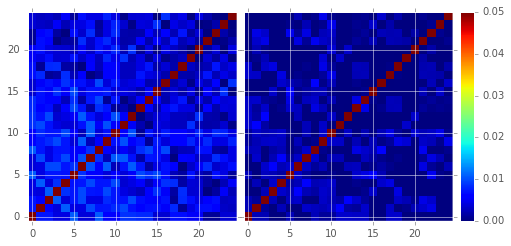

In [99]:
cov1 = dit.computePixelCovariance(np.nan_to_num(diffim))
cov2 = dit.computePixelCovariance(np.nan_to_num(pci))
dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.05), cmap=None)